# Home Credit - Modelling

In this notebook, we will
1. select an appropriate __evaluation matrix__
2. devise our __modelling and validation strategy__
3. select the __best model__ and
4. evaluate __business impact__

We will use the tidy data with newly derived features from the Feature Engineering notebook.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from scipy.stats import loguniform

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, cross_validate


from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report

%matplotlib inline
%precision %.2f

plt.style.use('bmh')
pd.set_option('display.max_rows', 30)
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_columns', 100)

# We will work with ~25% data in the process development phase.
process_dev_flag = False
random_seed = 79
lr_iterations = 10
xgb_iterations = 50
lgb_iterations = 50

In [2]:
train_path = '../data/interim/df_train_fe.csv'
test_path = '../data/interim/df_test_fe.csv'
dtype_path = '../data/interim/data_types_fe.csv'

In [3]:
df_train = pd.read_csv(train_path,index_col=0)
df_test = pd.read_csv(test_path,index_col=0)

df_dtype = pd.read_csv(dtype_path,index_col=0)
dict_dtype = df_dtype.dtype.to_dict()

df_train.shape, df_test.shape

((215249, 188), (92250, 188))

In [4]:
df_train = df_train.astype(dict_dtype)
df_test = df_test.astype(dict_dtype)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215249 entries, 0 to 215248
Columns: 188 entries, sk_id_curr to total_contact_flags
dtypes: float16(90), float64(28), int64(7), int8(35), object(28)
memory usage: 149.2+ MB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92250 entries, 0 to 92249
Columns: 188 entries, sk_id_curr to total_contact_flags
dtypes: float16(90), float64(28), int64(7), int8(35), object(28)
memory usage: 64.0+ MB


In [7]:
df_train.head()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_2,ext_source_3,basementarea_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingarea_avg,fondkapremont_mode,housetype_mode,wallsmaterial_mode,emergencystate_mode,...,nflag_insured_on_approval_sum,nflag_last_appl_per_contract_sum,nflag_last_appl_in_day_sum,pc_latest_contract_status_last,cr_latest_contract_status_last,name_client_type_last,name_yield_group_grp_mode,name_yield_group_last,name_payment_type_grp_mode,name_payment_type_last,product_combination_last,name_type_suite_last,channel_type_grp_mode,channel_type_last,code_reject_reason_grp_mode,code_reject_reason_last,prev_cnt_ct_cash_loans,prev_cnt_ct_consumer_loans,prev_cnt_ct_revolving_loans,prev_cnt_cs_approved,prev_cnt_cs_canceled,prev_cnt_cs_refused,prev_cnt_cs_unused_offer,prev_cnt_pt_xna,prev_cnt_pt_walk-in,prev_cnt_pt_x-sell,bc_cnt_loans,bc_cnt_credit_type,bc_sum_cnt_credit_prolong,bc_last_days,bc_amt_max_credit_overdue,bb_last_loan_status,bb_cnt_unique_loan_obs,bc_cnt_car_loan,bc_cnt_cr_type_others,bc_cnt_credit_card,bc_cnt_mortgage,bc_cnt_active,bc_cnt_cr_status_others,rt_credit_income,rt_annuity_income,rt_annuity_credit,rt_goods_price_credit,total_document_flags,rt_days_employed_birth,rt_days_id_birth,rt_phone_changed_birth,avg_family_income,avg_family_credit,total_contact_flags
0,389706,0,Revolving loans,0,0,0,2,45000.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.018204,-13349,-2716.0,-3004.0,-4335,NaN,1,0,1,1,0,Sales staff,4.0,3,SATURDAY,12,0,0,0,0,0,0,Self-employed,0.734375,0.667480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,5.0,5.0,Active,NaN,Repeater,high,low_action,Cash through the bank,Cash through the bank,POS household without interest,Unaccompanied,Credit and cash offices,Country-wide,XAP,XAP,2.0,3.0,0.0,4.0,0.0,1.0,0.0,3.0,0.0,2.0,2.0,1.0,0.0,-10.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.000000,0.150000,0.050000,1.000000,0,0.203461,0.324743,0.142183,11250.0,33750.0,3
1,225912,0,Revolving loans,1,0,0,1,103500.0,247500.0,12375.0,247500.0,Unaccompanied,Working,Secondary / secondary special,Widow,Rented apartment,0.020706,-15566,-648.0,-649.0,-4297,NaN,1,0,1,0,0,Laborers,2.0,2,WEDNESDAY,7,0,0,0,0,0,0,Industry: type 7,0.544922,0.845215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,Completed,NaN,New,low_normal,low_normal,Cash through the bank,Cash through the bank,POS mobile without interest,NaN,Country-wide,Country-wide,XAP,XAP,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,2.0,1.0,-6.0,0.0,NaN,0.0,0.0,0.0,4.0,0.0,3.0,0.0,2.391304,0.119565,0.050000,1.000000,0,0.041629,0.276050,0.027303,51750.0,123750.0,2
2,405407,0,Revolving loans,1,0,1,0,90000.0,135000.0,6750.0,135000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0.025162,-14437,-352.0,-786.0,-5261,NaN,1,0,1,0,0,High skill tech staff,1.0,2,SUNDAY,9,0,0,0,0,0,0,Business Entity Type 2,0.197510,NaN,0.059998,0.333252,0.375,0.0,0.102173,not specified,block of flats,"Stone, brick",No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,0.0,-1629.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.500000,0.075000,0.050000,1.000000,0,0.024382,0.364411,0.013091,90000.0,135000.0,2
3,172092,0,Cash loans,1,0,0,0,121500.0,254700.0,26874.0,225000.0,Unaccompanied,Working,

Getting the list of categorical features with more than 2 levels.

In [8]:
cat_object_var_path = '../data/interim/cat_encode_features.csv'
df_cat_object = pd.read_csv(cat_object_var_path,index_col=0)
cat_object_features = list(df_cat_object.cat_object)
len(cat_object_features)

28

Getting the list of categorical features with just 2 levels. These features are stored as integers.

In [9]:
cat_bin_path = '../data/interim/cat_bin_num_features.csv'
df_cat_bin_num = pd.read_csv(cat_bin_path,index_col=0)
cat_bin_num_features = list(df_cat_bin_num.cat_bin_num)
len(cat_bin_num_features)

34

Finally, remaining features are numerical

In [10]:
num_features = set(df_train.columns) - (set(cat_object_features) | set(cat_bin_num_features))
num_features = list(num_features)
num_features.remove('sk_id_curr')
num_features.remove('target')
print(len(num_features))

124


## Evaluation matrix

For Home Credit, it is equally important to  

1. Avoid customers who are likely to default on the loan and
2. Increase customers who are likely to pay back the loan

Given this business objective, we will be __using the roc_auc__ matrix as it considers both the classes(default/no default). 
The pr_auc matrix mainly cares about positive class(default). Hence, we will avoid it.  
Other important considerations in model evaluation will be __prediction time and training time__ in that order.

## Modelling Strategy

HomeCredit is more interested in accurate predictions than interpretations. Hence, we consider following algorithms for our classification task. 

1. __Logistic Regression with l1 regularization__ - Logistic regression is a simple linear algorithm with decent performance. As we have 180+ features and many are correlated features, we will use l1 regularization for feature selection. This will also be our base model.
2. __XgBoost__ - XgBoost is known to outperform linear models on tabular data in many cases.
3. __LightGBM__ - LightGBM is faster than XgBoost and tends to perform well on tabular data.

Logistic regression with manual/automatic feature selection resulting in parameter coefficients would be a better choice if transparency and simplicity was the preference.

### Handling missing values
1. __Categorical__ features - Create a seperate nan category/level for missing value. We will do this at the time of one-hot-encoding using pandas get_dummy function.
2. __Numerical__ features - For logistic regression, we will impute missing values with median because numerical features are highly skewed as observed in EDA. XgBoost & LightGBM can handle missing in a supervised way to optimize performance. Hence, we will not impute numerical features for these two algorithms. 


#### Creating dummy variables

In [11]:
df_train_dummies = pd.get_dummies(df_train,columns = cat_object_features, dummy_na=True)
df_test_dummies = pd.get_dummies(df_test,columns = cat_object_features, dummy_na=True)

Aligning test data with train data so that it has same feaures.

In [12]:
#source : https://kanoki.org/2019/08/27/pandas-dataframe-align-function/
df_train_dummies, df_test_dummies = df_train_dummies.align(df_test_dummies, join = 'left', axis = 1)
df_train_dummies.shape, df_test_dummies.shape

((215249, 423), (92250, 423))

In [13]:
new_features = [ col for col in df_train_dummies.columns if col not in df_train.columns]

In [14]:
X_train = df_train_dummies.drop(columns=['target','sk_id_curr'])
y_train = df_train_dummies.target

if process_dev_flag == True :
    records = 50000
    X_train = X_train[:records]
    y_train = y_train[:records]

X_test = df_test_dummies.drop(columns=['target','sk_id_curr'])
y_test = df_test_dummies.target

## Validation Strategy

We will use a __5-fold__ cross-validation strategy on train data for hyperparameter tuning and model selection. We will train these 3 models on same set train-validation datasets. To select the best hyperparameters, we will use __RandomSearchCV__ technique. 

And finally, we will test the performance of the best model on test the dataset. This will give us better idea of how well the model performs on unseen data.

In [15]:
num_folds = 5
cv = KFold(n_splits= num_folds, shuffle=True, random_state=random_seed)

### Logistic regression 
We will use median imputation to fill missing values for numerical features using column transformer. As we are using l1 regularization and for greater convergence speed, we will scale these features using StandardScaler.

We will tune the C (regularization) parameter using RandomSearchCV with 10 iterations.

In [16]:
numeric_transformer = Pipeline(steps=[
                                ('imputer', SimpleImputer(strategy="median")),
                                ('scaler',StandardScaler())])

preprocessor = ColumnTransformer( 
                    transformers=[('num', numeric_transformer, num_features)], 
                    remainder = 'passthrough',
                    sparse_threshold=0 ) # to get the dense matrix

# saga works with l1 penalty and tol is set to 1e-2 for faster convergence
classifier_lr = LogisticRegression(penalty='l1', solver = 'saga', 
                                   max_iter=500, tol = 1e-2, 
                                   random_state=random_seed)

clf_lr = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('classifier_lr', classifier_lr)])

param_dists = { 'classifier_lr__C': loguniform(1e-2, 1e2) }


In [17]:
%%time
cv_lr = RandomizedSearchCV(clf_lr, 
                           param_distributions=param_dists, 
                           scoring = 'roc_auc',
                           n_iter=lr_iterations, 
                           cv=cv, 
                           n_jobs= -2,
                           random_state = random_seed)

cv_lr.fit(X_train, y_train)

Wall time: 8min 35s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=79, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                sparse_threshold=0,
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['in_rt_amt_surplus_inst_last',
                                   

In [18]:
cv_lr_results = pd.DataFrame(cv_lr.cv_results_)

In [19]:
# modified from https://inria.github.io
def shorten_param_names_pipeline(param_name):
    """
    Shorten the hyperparameter names from CrossValidation results of pipeline.
    
    Keyword arguments:
    param_name -- column name of cv_results_ dataframe
    """
    
    if '__' in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

def shorten_param_names(param_name):
    """
    Shorten the hyperparameter names from CrossValidation results of model.
    
    Keyword arguments:
    param_name -- column name of cv_results_ dataframe
    """
    
    if 'param_' in param_name:
        return param_name.replace("param_", "")
    return param_name

In [20]:
# to get only the parameters columns
col_results = column_results = ['param_{}'.format(name) for name in param_dists.keys()]

# add score columns
column_results += ['mean_test_score', 'std_test_score', 'rank_test_score']

cv_lr_results = cv_lr_results[column_results].sort_values(
                            'mean_test_score', ascending=False)

cv_lr_results.columns = [shorten_param_names_pipeline(col) for col in cv_lr_results.columns]
cv_lr_results

,C,mean_test_score,std_test_score,rank_test_score
4,19.103447,0.764342,0.003913,1
7,18.210473,0.764342,0.003913,2
6,13.082658,0.764341,0.003913,3
2,1.007233,0.764326,0.003912,4
0,1.006173,0.764326,0.003912,5
1,0.745195,0.764320,0.003911,6
5,0.192955,0.764247,0.003903,7
9,0.081343,0.764055,0.003945,8
3,0.039511,0.763712,0.003884,9
8,0.011461,0.761508,0.003825,10


Top logistic regression model has 0.7643 mean AUC score. Also, top 3 models have same mean & standard deviation indicating the stability of the model. We have reduced tolerance level to 0.01 for faster convergence with less iterations. This will be our base model.

### XgBoost   

As XgBoost has more hyperparameters to tune, we will use __50 iterations__ in RandomSearch cross-validation. I have enabled GPU support for XgBoost training. 50 iterations are chosen considering the __time and hardware availability__.

In [21]:
gpu_params = {'tree_method':'gpu_hist', 
              'predictor':'gpu_predictor',
              'n_jobs': -1}

xgb_clf = xgb.XGBClassifier(objective= 'binary:logistic', max_delta_step = 1,
                             **gpu_params, use_label_encoder=False, 
                            seed=random_seed, verbosity=0)

xgb_param_dists = {'learning_rate': loguniform(0.001, 1),
               'max_depth' : [1,4,8,16],
               'min_child_weight' : [1,4,8],
               'colsample_bytree' : [0.6,0.8],
               'subsample' : [0.6,0.8],
               'n_estimators' : [200,400,800,1600,6400],
               'reg_alpha' : loguniform(0.001, 10) }


In [22]:
%%time
xgb_cv = RandomizedSearchCV(xgb_clf, 
                           param_distributions=xgb_param_dists, 
                           scoring = 'roc_auc',
                           n_iter=xgb_iterations, 
                           cv=cv, 
                           random_state = random_seed)

xgb_cv.fit(X_train, y_train)

Wall time: 14h 6min 10s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=79, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None, max_delta_step=1,
                                           max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           m...
                   param_distributions={'colsample_bytree': [0.6, 0.8],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BBB6C6A288>,
                  

In [23]:
xgb_cv_results = pd.DataFrame(xgb_cv.cv_results_)

# to get only the parameters columns
col_results = column_results = ['param_{}'.format(name) for name in xgb_param_dists.keys()]

# add score columns
column_results += ['mean_test_score', 'std_test_score', 'rank_test_score']

xgb_cv_results = xgb_cv_results[column_results].sort_values(
                            'mean_test_score', ascending=False)

xgb_cv_results.columns = [shorten_param_names(col) for col in xgb_cv_results.columns]
xgb_cv_results

,learning_rate,max_depth,min_child_weight,colsample_bytree,subsample,n_estimators,reg_alpha,mean_test_score,std_test_score,rank_test_score
39,0.02332,8,1,0.6,0.8,800,8.641093,0.782559,0.004699,1
43,0.013749,8,4,0.8,0.6,1600,0.005758,0.781800,0.005376,2
41,0.011852,16,1,0.6,0.8,1600,6.728249,0.781057,0.004862,3
46,0.032426,8,4,0.6,0.6,400,0.111382,0.779470,0.005455,4
22,0.001077,16,1,0.8,0.6,6400,8.086449,0.778962,0.005211,5
...,...,...,...,...,...,...,...,...,...,...
4,0.004059,16,1,0.8,0.6,200,0.001081,0.683303,0.006737,46
29,0.005323,1,4,0.8,0.6,200,0.97646,0.668475,0.003857,47
48,0.001278,8,4,0.8,0.6,400,1.598261,0.625659,0.003015,48
38,0.001941,1,4,0.8,0.8,200,0.066093,0.565414,0.004828,49


Top XgBoost model has __0.7826 mean AUC and 0.0047 standard deviation in AUC__. It is significantly better than Logistic Regression model with 0.7643.   
As we can see, XgBoost took 14+ hours to tune. 

### LightGBM   

Similar to XgBoost, LightGBM has more hyperparameters to tune. Hence, we will use __50 iterations__ in RandomSearch cross-validation. LightGBM is faster on multicore CPUs and enabling GPU support for LightGBM was challenging and unsuccessful.

In [24]:
# store original column names as LightGBM does not allow special characters in column names.
import re

X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

X_col_names = X_train.columns

X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


In [25]:
lgb_clf = lgb.LGBMClassifier(objective= 'binary',
                            random_state =random_seed)


lgb_param_dists = {
            'learning_rate': loguniform(0.01, 1),
            'n_estimators': [200,400,800,1600,6400],
            'num_leaves': [4,8,16,50],
            'min_child_weight' : [1,4,8,16],
            'colsample_bytree' : [0.6,0.8],
            'subsample' : [0.6,0.8,1],
            'reg_alpha': loguniform(0.001, 1)}

In [26]:
%%time
lgb_cv = RandomizedSearchCV(lgb_clf, 
                           param_distributions=lgb_param_dists, 
                           scoring = 'roc_auc',
                           n_iter=lgb_iterations, 
                           cv=cv, 
                           n_jobs= -2,
                           random_state = random_seed)

lgb_cv.fit(X_train, y_train)

Wall time: 1h 50min 49s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=79, shuffle=True),
                   estimator=LGBMClassifier(objective='binary',
                                            random_state=79),
                   n_iter=50, n_jobs=-2,
                   param_distributions={'colsample_bytree': [0.6, 0.8],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BB82F2CEC8>,
                                        'min_child_weight': [1, 4, 8, 16],
                                        'n_estimators': [200, 400, 800, 1600,
                                                         6400],
                                        'num_leaves': [4, 8, 16, 50],
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BB82F26588>,
                                        'subsample': [0.6, 0.8, 1]},
                   random_state=79, scoring='roc_auc')

In [27]:
lgb_cv_results = pd.DataFrame(lgb_cv.cv_results_)

# to get only the parameters columns
col_results = column_results = ['param_{}'.format(name) for name in lgb_param_dists.keys()]

# add score columns
column_results += ['mean_test_score', 'std_test_score', 'rank_test_score']

lgb_cv_results = lgb_cv_results[column_results].sort_values(
                            'mean_test_score', ascending=False)

lgb_cv_results.columns = [shorten_param_names(col) for col in lgb_cv_results.columns]
lgb_cv_results

,learning_rate,n_estimators,num_leaves,min_child_weight,colsample_bytree,subsample,reg_alpha,mean_test_score,std_test_score,rank_test_score
19,0.010235,6400,16,16,0.6,0.6,0.518502,0.781403,0.004963,1
14,0.013237,1600,50,8,0.8,0.8,0.067029,0.781227,0.005039,2
21,0.047418,800,8,8,0.6,0.8,0.072886,0.779739,0.004880,3
8,0.057575,1600,4,4,0.8,1,0.004349,0.779433,0.005544,4
48,0.037273,400,16,16,0.6,1,0.263301,0.779185,0.005300,5
...,...,...,...,...,...,...,...,...,...,...
26,0.775973,400,16,8,0.6,0.6,0.003888,0.701514,0.005351,46
7,0.755727,1600,8,16,0.8,1,0.020619,0.697540,0.004055,47
20,0.836162,800,16,16,0.6,0.6,0.10915,0.691807,0.003211,48
30,0.895656,400,50,1,0.6,0.6,0.196175,0.690632,0.005410,49


Top LightGBM model has __0.7814 mean AUC and 0.0049 standard deviation in AUC__. It is slightly less than top XgBoost model. __Both the scores are within 1 standard deviation of each other.__
LightGBM took 1 hour 50 minutes to tune. LightGBM with 5 CPU cores is 7 times faster than XgBoost and 6GB GPU. 

### Feature Importance :
Let's look at feature importance plot of XgBoost & LightGBM models. We will use Gains to calculate & compare feature importance.

In [28]:
best_xgboost_model = xgb_cv.best_estimator_

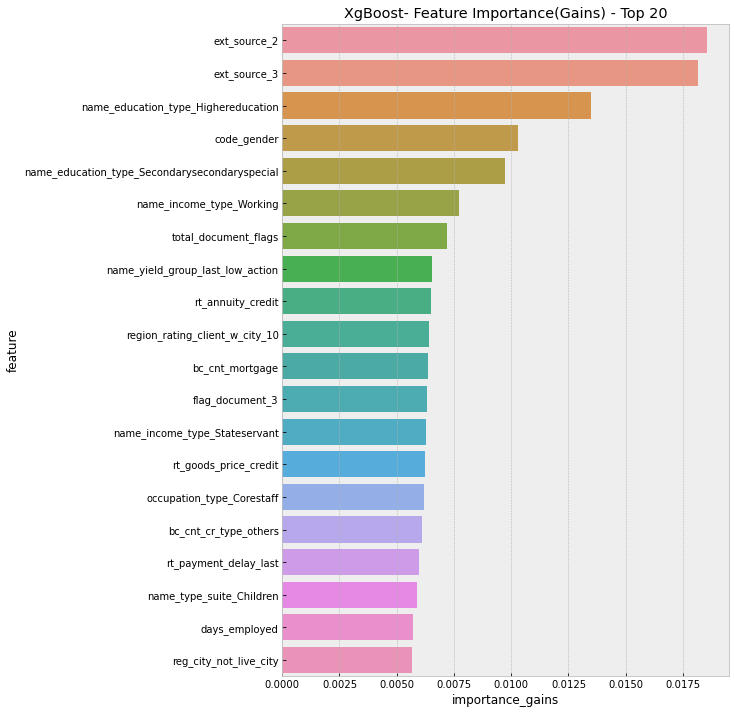

In [29]:
df_xgboost_feature_imp = pd.DataFrame(X_train.columns,columns=['feature'])
df_xgboost_feature_imp['importance_gains'] = best_xgboost_model.feature_importances_

df_xgboost_feature_imp.sort_values(by='importance_gains', ascending=False, inplace=True)
df_xgboost_feature_imp_top = df_xgboost_feature_imp.head(20)

fig, ax = plt.subplots(figsize=(8,12))
sns.barplot(x ='importance_gains', y='feature', data = df_xgboost_feature_imp_top)
plt.title('XgBoost- Feature Importance(Gains) - Top 20')
plt.show()

In [30]:
best_lightgbm_model = lgb_cv.best_estimator_

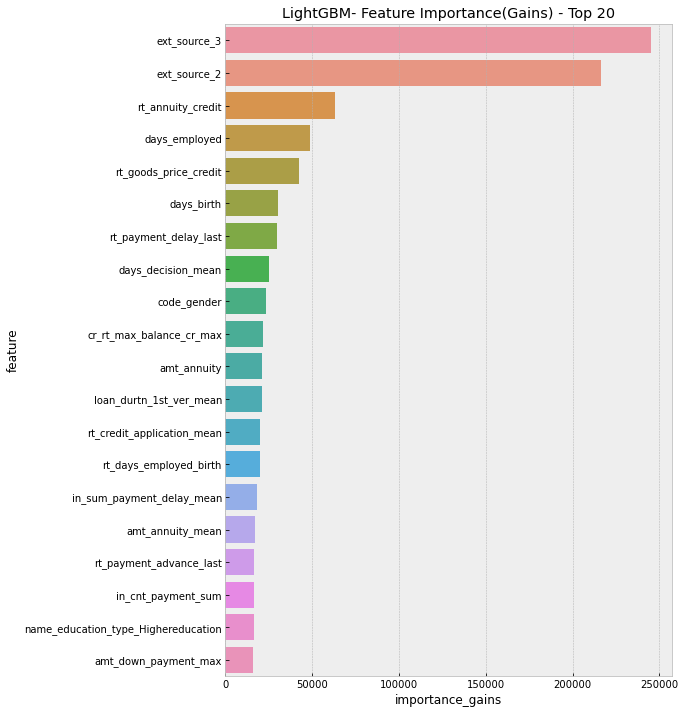

In [31]:
df_feature_imp = pd.DataFrame(X_train.columns,columns=['feature'])
df_feature_imp['importance_gains'] = best_lightgbm_model.booster_.feature_importance(importance_type='gain')
df_feature_imp['importance_split'] = best_lightgbm_model.booster_.feature_importance(importance_type='split')

df_feature_imp.sort_values(by='importance_gains', ascending=False, inplace=True)
df_featture_imp_top = df_feature_imp.head(20)

fig, ax = plt.subplots(figsize=(8,12))
sns.barplot(x ='importance_gains', y='feature', data = df_featture_imp_top)
plt.title('LightGBM- Feature Importance(Gains) - Top 20')
plt.show()

In [33]:
# Common features in top 20
set(df_xgboost_feature_imp_top.feature) & set(df_featture_imp_top.feature)

{'code_gender',
 'days_employed',
 'ext_source_2',
 'ext_source_3',
 'name_education_type_Highereducation',
 'rt_annuity_credit',
 'rt_goods_price_credit',
 'rt_payment_delay_last'}

External feature 2 & 3 are top two features in both the models. 
It is assuring that we observed trends in many of the top 20 features during EDA. Derived __Ratio features__ are coming out to be important predictors.  

#### Comparison

We have 8 common features in top 20 between XgBoost & LightGBM. XgBoost has more categorical features in top 20 whereas LightGBM has more continuous features in top 20. This may need further investigation.


In [34]:
%%time
y_train_pred_probs = best_xgboost_model.predict_proba(X_train)[:,1]

Wall time: 20.4 s


In [35]:
%%time
y_train_pred_probs = best_lightgbm_model.predict_proba(X_train)[:,1]

Wall time: 36.8 s


XgBoost prediction is 1.8 times faster than LightGBM prediction.

Hence, we will select __XgBoost  as the best model__ because
1. slightly higher accuracy (0.7826 vs 0.7814)
2. faster prediction time (20.4 s vs 36.8 s)

Let us analyize features with null importance.

In [36]:
null_imp_features = df_xgboost_feature_imp.loc[df_xgboost_feature_imp.importance_gains ==0, 'feature'].values

In [37]:
print('Number of Features with NULL Importance : {} '.format(len(null_imp_features)))
print("Features : ")
null_imp_features

Number of Features with NULL Importance : 111 
Features : 


array(['organization_type_Tradetype6', 'organization_type_Tradetype5',
       'pc_latest_contract_status_last_Returnedtothestore',
       'organization_type_Tradetype4', 'name_housing_type_nan',
       'organization_type_Tradetype1', 'organization_type_Telecom',
       'flag_document_7', 'flag_document_9',
       'pc_latest_contract_status_last_nan', 'flag_document_10',
       'name_payment_type_grp_mode_Cashlessfromtheaccountoftheemployer',
       'name_payment_type_grp_mode_Noncashfromyouraccount',
       'organization_type_Religion',
       'pc_latest_contract_status_last_Signed',
       'organization_type_University', 'organization_type_Transporttype1',
       'flag_document_4', 'flag_document_12',
       'name_payment_type_last_Cashlessfromtheaccountoftheemployer',
       'name_payment_type_last_Noncashfromyouraccount',
       'reg_region_not_live_region', 'name_payment_type_last_nan',
       'name_housing_type_Coopapartment', 'name_yield_group_last_nan',
       'product_combinati

Organization type, last loan status from balance bureau, payment type of last loans and some flags features seem to be not at all importance. Let's remove these features and cross-validate the XgBoost model.

In [44]:
X_train_dimR = X_train.drop(columns = list(null_imp_features))
print(X_train_dimR.shape)
best_model_DimR = xgb.XGBClassifier()
best_model_DimR.set_params(**best_xgboost_model.get_params())

cv_dimR = cross_validate(best_model_DimR, X_train_dimR, y_train, cv = cv, scoring = 'roc_auc')
test_scores = cv_dimR["test_score"]

(215249, 310)


In [45]:
print('AUC score mean :  {:.4f} std : {:.4f} '.format(test_scores.mean(), test_scores.std()))

AUC score mean :  0.7827 std : 0.0052 


We have almost same score after removing these null importance features. But as we have noticed from feature importance camparison, ranking can somewhat differ by algorithms even when the algorithm performances are close. Assumig 423 features are manageable, let us not remove these features untill further investigation.

### Prediction on Test Data

In [46]:
# changing column names for X_test as we removed special characters from column names for X_train while training LightGBM
X_test.columns = X_train.columns

In [47]:
y_pred_probs = best_xgboost_model.predict_proba(X_test)[:,1]
roc_auc_score(y_test.values, y_pred_probs)

0.7841453976662032

AUC of __0.7841__ is slightly higher than __0.7814__ mean AUC of cross-validation but well within the range __(0.7861, 0.7767)__ of 1 standard deviation. XgBoost model has well generalized on test set.   

Let us look at model performance in detail using ROC curve and confusion matrix.

In [48]:
fpr, tpr, thresholds = roc_curve(y_test.values, y_pred_probs)

In [49]:
# To get the best threshold, we will use J statistics
# source : https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
# https://en.wikipedia.org/wiki/Youden%27s_J_statistic
j_stat = tpr - fpr
ix = np.argmax(j_stat)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.073093


J statistics achieves optimum balance between tpr & fpr by giving equal weight to false positive and false negative pay-offs.

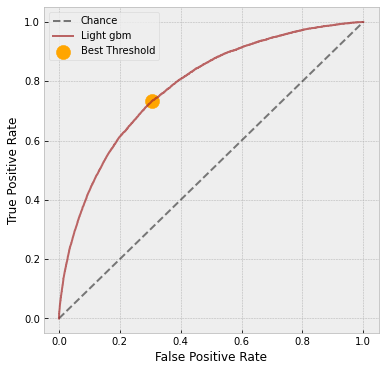

In [50]:
# plot the roc curve for the model
fig, ax = plt.subplots(figsize=(6,6))
plt.plot([0,1], [0,1], linestyle='--', label='Chance', color='k', alpha= 0.5)
plt.plot(fpr, tpr, linestyle='-',label='Light gbm', color='brown', alpha= 0.7)
plt.scatter(fpr[ix], tpr[ix], marker='o', s=200, color='orange', label='Best Threshold')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [51]:
# Corresponding fpr & tpr
print('Best Threshold: {}'.format(round(best_thresh,4)))
print('Corresponding fpr : {} and tpr: {}'.format(round(fpr[ix],4), round(tpr[ix],4)))

Best Threshold: 0.0731000006198883
Corresponding fpr : 0.3044 and tpr: 0.7324


In [52]:
def get_confusion_matrix(y_probabilities, y_true, threshold):
    """
    Get the confusion matrix using specified threshold
    
    Keyword arguments:
    y_probabilities -- predicted probabilities of positive class
    y_true -- true value of y
    threshold -- threshold to use to get 0/1 prediction
    
    Returns :
    2*2 confusion_matrix
    """
    y_pred = np.zeros(y_true.shape)
    y_pred = np.where( y_probabilities > threshold ,1, 0 )
    return confusion_matrix(y_test, y_pred)

conf_matx = get_confusion_matrix(y_pred_probs, y_test, best_thresh)

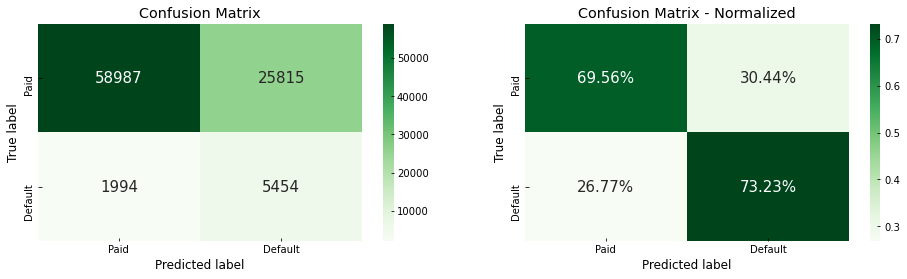

In [53]:
def custom_plot_confusion_matrix(confusion_matrix_array):
    """
    Plot the confusion matrix
    
    Keyword arguments:
    confusion_matrix -- 2*2 confusion matrix
    """
    
    fig, ax = plt.subplots(1,2, figsize=(16,4))
    display_labels = ['Paid', 'Default']
    sns.heatmap(confusion_matrix_array, xticklabels = display_labels, yticklabels = display_labels, 
                annot=True, cmap='Greens', fmt='d', annot_kws={"size": 15}, ax=ax[0])
    ax[0].set_ylabel('True label')
    ax[0].set_xlabel('Predicted label')
    ax[0].set_title('Confusion Matrix')
    
    confusion_matrix_norm = confusion_matrix_array/confusion_matrix_array.sum(axis=1).reshape(-1,1)
    sns.heatmap(confusion_matrix_norm, xticklabels = display_labels, yticklabels = display_labels, 
                annot=True, cmap='Greens', fmt=".2%", annot_kws={"size": 15}, ax=ax[1])
    ax[1].set_ylabel('True label')
    ax[1].set_xlabel('Predicted label')
    ax[1].set_title('Confusion Matrix - Normalized')
    
    
custom_plot_confusion_matrix(conf_matx)

Normalization is done as a % of true labels. We are able to correctly identify 73.23% of truely default loans and 26.77% of the default loans are missed with the selected thresold. Also, we are missing out in lending to 30.44% of truely payable loans by identifying them as potentially default loans. We are giving loans to 60981(58987+1994) applications which is 66.10% of total applications. Let us extend this analysis by incorperating pay-offs associated with each class. 

## Business Performance

Assume that HomeCredit wants to __maximize profit__ as a business objective. We have following parameters from business.
1. __5% of credit as a final profit__ on loans which are fully paid - this is the average % profit after removing commission, expenses, cost of capital etc.
2. __40% of credit as a loss__ on loans which are defaulted - this is the average % loss after considering outstanding amount, recoveries etc. 90% of loans are cash loans and losses tend to be higher on cash loans. 


With this in mind, let us optimize the threshold for maximum profit and calculate confusion matrix. Now we will
1. calculate average loan size for paid and default loans
2. create a class for business parameters
3. create a function to calculate expected profit at given threshold
4. simulate different scenarios and plot profitability curve.

In [54]:
mean_credit_paid = df_test.loc[df_test.target==0, ].amt_credit.mean()
mean_credit_default = df_test.loc[df_test.target==1, ].amt_credit.mean()
mean_credit_paid,mean_credit_default

(601969.81, 554235.12)

In [55]:
profit_on_paid_loans = 0.05
loss_on_default_loans = 0.40

class cls_business_params:
    """
    Class to store business information regarding loan size, profit/loss
    set_business_params - to set the values of business parameters
    get_business_params - to get the values of business parameters
    """

    def __init__(self,mean_credit_paid,mean_credit_default,profit_on_paid_loans,loss_on_default_loans): 
        # instance as passed as a first agrument. Referred as self
        self.mean_credit_paid = mean_credit_paid
        self.mean_credit_default = mean_credit_default
        self.profit_on_paid_loans = profit_on_paid_loans
        self.loss_on_default_loans = loss_on_default_loans
        
    def set_business_params(mean_credit_paid,mean_credit_default,profit_on_paid_loans,loss_on_default_loans):
        self.mean_credit_paid = mean_credit_paid
        self.mean_credit_default = mean_credit_default
        self.profit_on_paid_loans = profit_on_paid_loans
        self.loss_on_default_loans = loss_on_default_loans        
    
    def get_business_params(self):
        return mean_credit_paid, mean_credit_default, profit_on_paid_loans, loss_on_default_loans
    
business_params = cls_business_params(mean_credit_paid,mean_credit_default,profit_on_paid_loans,loss_on_default_loans)

In [56]:
def calculate_expectancy(confusion_matrix, business_params):
    """
    Calculates  business expectancy/profit 
    
    Keyword arguments:
    confusion_matrix -- to set the values of business parameters
    business_params -- instance of  business_params containing profit,/loss, loan size values
    Returns :
    expectancy -- profit/loss based on confusion matrix and business parameters
    """
    tn, fp, fn, tp = confusion_matrix.flatten()
    mean_credit_paid, mean_credit_default, profit_on_paid_loans, loss_on_default_loans = business_params.get_business_params()

    expectancy = (tn * mean_credit_paid * profit_on_paid_loans         # profit from fully paid loans
                + tp * mean_credit_default * loss_on_default_loans     # notional profit from avoiding defaults 
                - fp * mean_credit_paid * profit_on_paid_loans         # notional loss from avoiding potentially paid back loans
                - fn * mean_credit_default * loss_on_default_loans)    # loss from deafults on loans

    return expectancy

In [57]:
def plot_profitability_curve(y_probabilities, y_true, business_params):
    """
    Plots profit against thresholds for positive class
    
    Keyword arguments:
    y_probabilities -- predicted probabilities of positive class
    y_true -- true value of y
    business_params -- instance of  business_params containing profit,/loss, loan size values
    Returns :
    max_profit -- maximum profit achievable with business constraints and model capabilities
    max_profit_threshold -- positive class threshold associated with maximum profit
    """

    thresholds = np.linspace(0,1,30)
    expectancy = []
    for threshold in thresholds:
        conf_matx = get_confusion_matrix(y_probabilities, y_true, threshold)
        expt = calculate_expectancy(conf_matx, business_params)
        expectancy.append(expt)
    
    idx = np.argmax(expectancy)
    max_profit = np.max(expectancy)
    max_profit_threshold = thresholds[idx]

    fig, ax = plt.subplots(figsize=(7,5))
    plt.plot(thresholds, expectancy, linestyle='-',label='profit', color='brown', alpha= 0.7)
    #plt.scatter(max_profit_threshold, max_profit, marker='o', s=200, color='orange', label='Best Threshold')
    max_profit_fmt = 'Max profit: {0:.1f} billion'.format(max_profit/1e9)
    max_profit_fmt  
    ax.annotate(max_profit_fmt, xy=(max_profit_threshold, max_profit),  xycoords='data',
            xytext=(0.6, 0.92), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',
            fontsize=13)
    
    plt.xlabel('Thresholds')
    plt.ylabel('Profits')
    plt.legend()
    plt.title('Profitability Curve')
    plt.show()
    
    return max_profit, max_profit_threshold

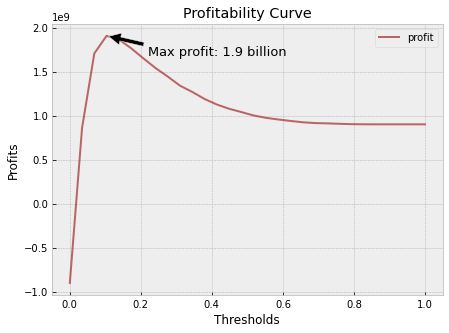

Profit Maximizing Threshold: 0.1034
Corresponding Profit : 1906598992


In [58]:
max_profit, max_profit_threshold = plot_profitability_curve(y_pred_probs, y_test, business_params)
print('Profit Maximizing Threshold: {}'.format(round(max_profit_threshold,4)))
print('Corresponding Profit : {}'.format(round(max_profit)))

We see that maximum profit of 1.9 billion(test data) will be achived at 0.1034 threshold. This threshold is higher than J statistics based threshold. Let us plot confusion matrix using this threshold.

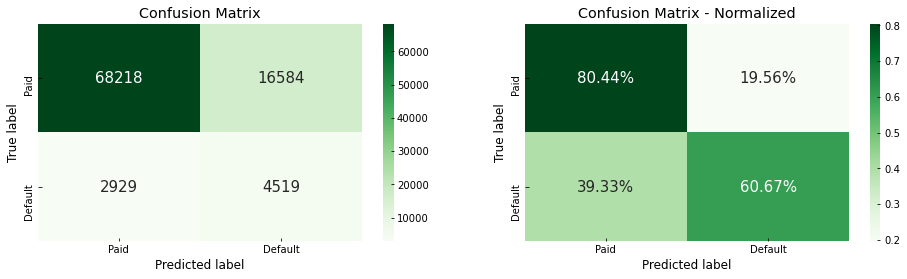

In [59]:
max_profit_conf_matx = get_confusion_matrix(y_pred_probs, y_test, max_profit_threshold)
custom_plot_confusion_matrix(max_profit_conf_matx)

For profit maximization, we relax the threshold and extend the loans to 71147 (77.12%) applications. This is 11 % points or 10166 applications higher than previous analysis. Given the pay-offs, we can accommodate 935 (2929-1994) additional defaults  which are more than compensated for by approving additional 9231 (68218-58987) payable loans.

In [84]:
tpr_profit = max_profit_conf_matx[1][1] / (max_profit_conf_matx[1][0] + max_profit_conf_matx[1][1])
fpr_profit = max_profit_conf_matx[0][1] / (max_profit_conf_matx[0][0] + max_profit_conf_matx[0][1])
print('Max profit fpr : {} and tpr: {}'.format(round(fpr_profit,4), round(tpr_profit,4)))

Max profit fpr : 0.1956 and tpr: 0.6067


### Profit %
Assuming that we will accept all the applications that are predicted as paid and reject all the application that are predicted as default, let us calculate the expected booked profit %.

In [85]:
mean_credit_paid, mean_credit_default, profit_on_paid_loans, loss_on_default_loans = business_params.get_business_params()

potential_credit_given = (max_profit_conf_matx[0][0] * mean_credit_paid        # loan given and paid back
                         + max_profit_conf_matx[1][0] * mean_credit_default    # loan given and defaulted
                         )

book_profit = (max_profit_conf_matx[0][0] * mean_credit_paid * profit_on_paid_loans        # profit on paid loans
              - max_profit_conf_matx[1][0] * mean_credit_default * loss_on_default_loans)  # loss on default loans

print('*****   Expected booked profit : {:.2%}   *****'.format(book_profit/potential_credit_given))

*****   Expected booked profit : 3.29%   *****


With this recommendation, we conclude HomeCredit default prediction project.

### Next Steps  
Following ideas can be explored in the future  
1. Modelling applicants with and without credit card separately - We have just about 28% applicants who had credit cards with HomeCredit but the records are credible(65k). This leads to missing values in most of the records. Also, applicants without credit cards have a 1.2% points higher default rate. Separating these two groups may lead to better accuracy.
2. Baysian Hyperparameter Optimization - We can explore Bayesian Hyperparameter Optimization which is a targeted search strategy based on model improvements. This may lead to improved tuning at a lesser time.
3. Feature Importance - We had seen that feature importance can differ by algorithms with almost same performance. This needs further investigation.
4. Model Interpretation - HomeCredit is more focused on prediction. But this is a good to have feature where we can demonstrate impact of the individual feature for easy buy-in of the model by business.

In [90]:
import os
import pickle
import datetime
from sklearn import __version__ as sklearn_version


final_model = best_xgboost_model
final_model.version = '1.0'
final_model.pandas_version = pd.__version__
final_model.numpy_version = np.__version__
final_model.sklearn_version = sklearn_version
final_model.xgboost_version = xgb.__version__
final_model.X_columns = [col for col in X_train.columns]
final_model.build_datetime = datetime.datetime.now()

In [91]:

modelpath = '../models'
model_name = 'home_credit_loan_default_model.pkl'
fpath = os.path.join(modelpath, model_name)

with open(fpath, 'wb') as f:
            pickle.dump(final_model, f)


In [99]:
xgb_tune_results = '../reports/model_tunning/xgb_tune_results.csv'
xgb_cv_results.to_csv(xgb_tune_results)

lgb_tune_results = '../reports/model_tunning/lgb_tune_results.csv'
lgb_cv_results.to_csv(lgb_tune_results)
